## ET
Calculate Potential Evapotranspiration for Lower Yakima Watershed (HUC8 Code = 17030003)
Using FAO PENMAN-MONTEITH WITH ONLY MINIMUM AND MAXIMUM TEMPERATURE
Equation from pg 8 of: 
https://farmwest.com/images/clientpdfs/FAO%20Penman-Monteith%20Equation%20for%20ET.pdf

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  2 08:24:34 2020

@author: parisajune
"""
# Calculate Potential Evapotranspiration for Lower Yakima Watershed (HUC8 Code = 17030003)
# Using FAO PENMAN-MONTEITH WITH ONLY MINIMUM AND MAXIMUM TEMPERATURE Equation from pg 8 of: 
# https://farmwest.com/images/clientpdfs/FAO%20Penman-Monteith%20Equation%20for%20ET.pdf

# Disclaimer: some of these libraries may be unused - imported just in case
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline 
import contextily as cx
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm
from shapely.geometry import box
from shapely.geometry import point 
import pynhd as nhd
import pygeoogc as geoogc
import pygeoutils as geoutils
import hydrodata as hd
import datetime

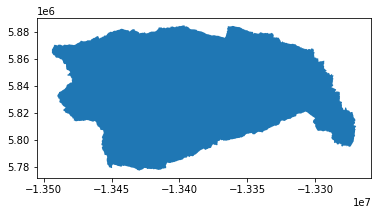

In [4]:
# Import Lower Yakima Shapefile
ly_gdf = gpd.read_file('data/HUC8/HUC8-17030003.shp')
ly_gdf.plot();

In [5]:
# Extract the outer bounding box coordinates of watershed (CRS= EPSG:3857)
ly_bbox = gpd.GeoSeries(box(*ly_gdf.total_bounds), crs=ly_gdf.crs)

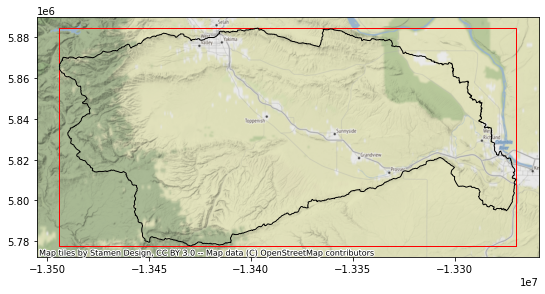

In [6]:
# Plot watershed within bounding box with basemap
ly_ax = ly_bbox.plot(edgecolor="red", facecolor='none', figsize=(9, 9))
ly_gdf.plot(ax=ly_ax, edgecolor='black', facecolor='none')
cx.add_basemap(ly_ax)

In [7]:
# Load csv of daily temperature [deg C] data from Yakima, Benton, and Klickitat Counties 1/1/15 - 8/31/20
# Source: https://www.ncdc.noaa.gov/cdo-web/
# Documentation (including attribute codes): 
# https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf

# Updated csv to include entire Lower Yakima Watershed; did not screen out points outside of the watershed boundary
# (Since they should get screened out when we link them to the crop areas)
T_csv = "data/yakima_benton_klickitat_temp_20150101_20200831.csv" 
T_df = pd.read_csv(T_csv, nrows=83338)
T_gdf = gpd.GeoDataFrame(T_df, geometry=gpd.points_from_xy(T_df.LONGITUDE, T_df.LATITUDE))

In [8]:
# Set CRS for simple geometry points 
T_gdf.crs = {'init' :'epsg:4326'}  

T_df_coord = T_df[['LATITUDE', 'LONGITUDE']]
T_df_unique_coords = T_df_coord.drop_duplicates()
T_gdf_unique_coords = gpd.GeoDataFrame(
    T_df_unique_coords, geometry=gpd.points_from_xy(
        T_df_unique_coords.LONGITUDE, T_df_unique_coords.LATITUDE))
T_gdf_unique_coords.crs = {'init' :'epsg:4326'}  

In [9]:
# Extract the outer bounding box coordinates of temperature measurement locations
T_bbox = gpd.GeoSeries(box(*T_gdf_unique_coords.total_bounds), crs=T_gdf_unique_coords.crs)

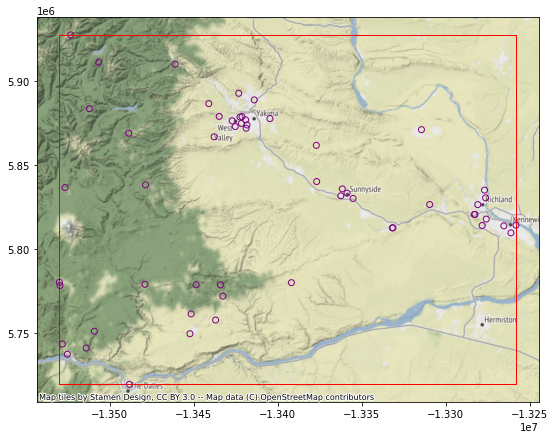

In [10]:
# Plot temperature data locations
T_ax = T_bbox.to_crs(epsg=3857).plot(edgecolor="red", facecolor='none', figsize=(9, 9))
T_gdf_unique_coords.to_crs(epsg=3857).plot(ax=T_ax, edgecolor='purple', facecolor='none')
cx.add_basemap(T_ax)

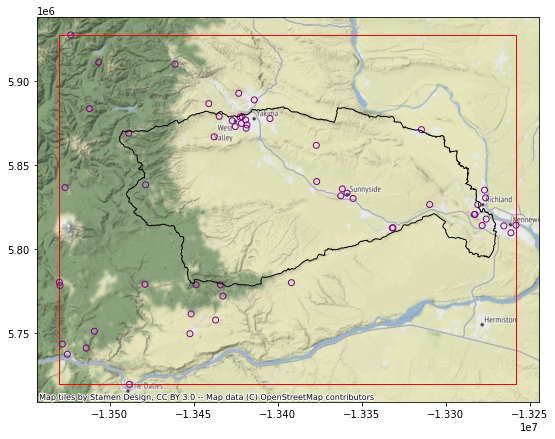

In [12]:
# Plot temperature data locations and watershed on same map
T_ax = T_bbox.to_crs(epsg=3857).plot(edgecolor="red", facecolor='none', figsize=(9, 9))
T_gdf_unique_coords.to_crs(epsg=3857).plot(ax=T_ax, edgecolor='purple', facecolor='none')
ly_gdf.plot(ax=T_ax, edgecolor='black', facecolor='none')
cx.add_basemap(T_ax)

In [13]:
# Make new temperature dataframe with only applicable info
T_gdf_clean = T_gdf[['LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'TAVG', 'TMAX', 'TMIN', 'geometry']]
T_gdf_clean = T_gdf_clean.dropna(subset=['TAVG', 'TMAX', 'TMIN'], how='all')

In [14]:
### Calculate ET_o!
## Data Required
# Elevation [m]
# Latitude [deg]
# Min Temp [deg C]
# Max Temp [deg C]
# Classification as Coastal or Interior
# Classification as Arid or Humid
# Julian day

# Convert date strings into Julian days
def datestdtojd (stddate):
    fmt='%Y-%m-%d'
    sdtdate = datetime.datetime.strptime(stddate, fmt)
    sdtdate = sdtdate.timetuple()
    jdate = sdtdate.tm_yday
    return(jdate)
T_gdf_clean_jd = T_gdf_clean['DATE'].apply(datestdtojd)
T_gdf_clean['J'] = T_gdf_clean_jd 

In [15]:
## Data Assumed or Constants
# Wind Speed [m/s]
u2 = 2
# Albedo or Canopy Reflection Coefficient
a = 0.23
# Solar Constant [MJ-2*min-1]
G_sc = 0.082
# Interior and Coastal Coefficients, K_Rs
# Interior Coefficient = 0.16
# Coastal Coefficient = 0.19
# Yakima is east of the Cascade Mountains:
K_Rs = 0.17
# Region Coefficient, K_O [deg C]
# Humid = 0, Arid = 2
# Yakima has a semi-arid climate: 
K_O = 1.5

In [16]:
## Procedure
# Calculate the daily mean air temperature [deg C], if not provided 
T_gdf_clean_avg = T_gdf_clean.TAVG.fillna((T_gdf.TMAX + T_gdf.TMIN)/2)
T_gdf_clean['TAVG'] = T_gdf_clean_avg

In [17]:
# Calculate actual vapor pressure [kPa]
e_a = 0.6108 * np.exp((17.27*(T_gdf_clean.TMIN - K_O)) / 
                      ((T_gdf_clean.TMIN - K_O) + 237.3))

In [18]:
# Calculate saturated vapor pressure for TMAX [kPa]
e_Tmax = 0.6108 * np.exp((17.27*T_gdf_clean.TMAX) / 
                      (T_gdf_clean.TMAX + 237.3))

In [19]:
# Calculate saturated vapor pressure for TMIN [kPa]
e_Tmin = 0.6108 * np.exp((17.27*T_gdf_clean.TMIN) / 
                      (T_gdf_clean.TMIN + 237.3))

In [20]:
# Calculate saturated vapor pressure [kPa]
e_s = (e_Tmin + e_Tmax)/2

In [21]:
# Calculate inverse relative distance Earth-Sun [rad]
d_r = 1 + 0.033 * np.cos(((2*np.pi / 365) * T_gdf_clean.J))

In [22]:
# Convert latitude to radians
lat_rad = (np.pi / 180) * T_gdf_clean.LATITUDE

In [23]:
# Calculate solar declination [rad]
solar_dec = 0.409 * np.sin(((2*np.pi / 365) * T_gdf_clean.J) - 1.39)

In [24]:
# Calculate sunset hour angle [rad]
angle_sunset = np.arccos(-np.tan(solar_dec) * np.tan(lat_rad))

In [25]:
# Calculate extraterrestrial radiation [MJm-2 day-1] 
R_a = (24 * 60 / np.pi) * G_sc * d_r * ((angle_sunset * np.sin(lat_rad) 
                                        * np.sin(solar_dec))
                                        + (np.cos(lat_rad) 
                                        * np.cos(solar_dec)
                                        * np.sin(angle_sunset)))

In [26]:
# Calculate clear sky solar radiation [MJm-2 day-1] 
R_so = (0.75 + (2 * 10**-5) * T_gdf_clean.ELEVATION) * R_a

In [27]:
# Calculate solar radiation [MJm-2 day-1]
R_s = K_Rs * R_a * (T_gdf_clean.TMAX - T_gdf_clean.TMIN)**0.5

In [28]:
# Calculate net longwave radiation [MJm-2 day-1] 
sigma = 4.903 * 10**-9 #MJK-4m-2day-1 
R_nl = sigma * 0.5 * ((T_gdf_clean.TMAX + 273.16)**4 + 
                      (T_gdf_clean.TMIN + 273.16)**4) * (0.34 - 0.14*(e_a**0.5)) * (1.35 * (R_s / R_so) - 0.35)

In [29]:
# Calculate net solar radiation [MJm-2 day-1] 
R_ns = (1-0.23) * R_s

In [30]:
# Calculate net radiation [MJm-2 day-1] 
R_n = R_ns - R_nl

In [31]:
# Calculate slope vapor pressure [kPa °C-1] 
slope_vp = (2504 * np.exp((17.27*T_gdf_clean.TAVG) / (T_gdf_clean.TAVG + 237.3))) / ((T_gdf_clean.TAVG + 237.3)**2)

In [32]:
# Calculate atmospheric pressure [kPa] 
P = 101.3 * (((293 - 0.0065 * T_gdf_clean.ELEVATION) / 293)**5.26)

In [33]:
# Calculate psychometric constant [kPa °C-1] 
psy = (0.665 * 10**-3) * P

In [34]:
# Calculate (daily) evapotranspiration [mm/day]!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ET_o = (0.408 * slope_vp * R_n + psy * (900 / (T_gdf_clean.TAVG + 273)) * u2 * (e_s - e_a)) / (slope_vp + psy * (1+0.34*u2)) 
ET_o_gdf = gpd.GeoDataFrame(ET_o, geometry=T_gdf_clean.geometry)
ET_o_gdf['DATE'] = T_gdf_clean.DATE

In [35]:
# Aggregate to monthly evapotranspiration
# Check if location is equal and, within that, if year and month are equal; then sum all in group

ET_o_gdf['YearMonth'] = ET_o_gdf['DATE'].str[:7]

ET_o_gdf['lon'] = ET_o_gdf.geometry.x
ET_o_gdf['lat'] = ET_o_gdf.geometry.y
ET_o_gdf = ET_o_gdf.rename(columns={0: "ETo"})

ET_o_monthly_sum = ET_o_gdf.groupby(['YearMonth', 'lon', 'lat'])["ETo"].sum()
ET_o_monthly_avg = ET_o_gdf.groupby(['YearMonth', 'lon', 'lat'])["ETo"].mean()

ET_o_monthly_avg_scaleup = ET_o_monthly_avg * 30
# Export to csv 
ET_o_monthly_avg_scaleup.to_csv('data/ET_o_Estimate_PJS.csv')